In [9]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Clip Basins

In [140]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
image = ee.Image("WWF/HydroSHEDS/3CONDEM");
bBox = ee.Geometry.BBox(112, -40, 165, -8);
image = image.clip(bBox)

In [14]:
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [ ]:
import json 
from ee.geometry import Geometry
basin_slopes = gpd.GeoDataFrame()
basin_slopes_t = gpd.GeoDataFrame()

shps = []
for i,row in a.iterrows():
    try:
        sh = list(zip(row.geometry.exterior.coords.xy[0],row.geometry.exterior.coords.xy[1]))
    except:
        sh = list(zip(row.geometry[1].exterior.coords.xy[0],row.geometry[1].exterior.coords.xy[1]))
    shp = Geometry.Polygon(sh)
    shps.append(shp)

In [ ]:
c=2254
while c < 2258:
    c+=1
    image = ee.Image("WWF/HydroSHEDS/03CONDEM");
    image = image.clip(shps[c])
    mytask = ee.batch.Export.image.toDrive(image=image, folder='data_earth_engine', description='hydrosheds_bas_'+ str(c))
    mytask.start()

In [ ]:
f = simplem.fs()
f.sinkfill()

In [ ]:
plt.plot(np.log(eromap[0:30]))

## Start running flowacc / chi calc on all basin

In [ ]:
#f.acc()
f.A.ravel()[f.A.ravel()>0][np.argmax(A.ravel()[f.A.ravel()>0])]


In [ ]:
np.sum(slps[slps<1])

In [32]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
eros1 = np.zeros(3600)
eros2 = np.zeros(3600)
slps1 = np.zeros(3600)
slps2 = np.zeros(3600)
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [18]:
for c in range(1,30):
    try:
        print(c)
        
        dem = rasterio.open('/Users/gr_1/Google Drive/data_earth_engine/hydrosheds_bas_{}.tif'.format(str(c)))
        lat = dem.xy(0,0)[1]
        dx = np.cos(lat/180*np.pi) * (1852/60)
        f = simplem.fs()
        f.dx = dx
        f.dy = 90

        f.set_z(np.float64(np.squeeze(dem.read())))
        f.BC = np.where(f.Z.transpose().ravel()<=0)[0]
        f.k[f.Z == 0] = 0
        f.sinkfill()
        f.slp()
        slps = f.slps.copy()

        f.dt = 1000
        f.stack()
        f.acc()
        
        Zi = f.Z.copy()

        ero = f.erode_other()
        #f.slp_mn()

        A=f.A.copy()
        f.stack()
        slps[slps>1]= 0
        #f.slp()
        f.acc()
        f.acc(ero)
        eros1[c] = np.mean(slps.ravel()[np.logical_and(f.Z.ravel()>1,f.slps.ravel()<1)])
        #eros1[c] = (f.A.ravel()[f.Z.ravel()>0][np.argmax(A.ravel()[f.Z.ravel() > 0])])/np.max(A.ravel()[f.Z.ravel()>0])
        f.slp()
        f.stack()
        f.acc()
        f.acc(slps)
        slps1[c] = (f.A.ravel()[f.Z.ravel()>0][np.argmax(A.ravel()[f.Z.ravel() > 0])])/np.max(A.ravel()[f.Z.ravel()>0])
        
        #f.slp_mn()
        
#         slps = f.slps.copy()
#         f.slp()
#         slps[slps>1] = 0
#         f.acc(slps)
#         slps2[c] = (f.A.ravel()[f.Z.ravel()>0][np.argmax(A.ravel()[f.Z.ravel() > 0])])/np.max(A.ravel()[f.Z.ravel()>0])

        #print(np.mean(f.slps.ravel()[A.ravel()>1]))
       # print(f.A.ravel()[np.argmax(A.ravel())]/np.max(A.ravel()))
        print(np.sum(slps.ravel()[np.logical_and(f.Z.ravel()>1,f.slps.ravel()<1)]))
        print(max(f.A.ravel()))#[np.argmax(A.ravel())])
       
    except:
        print('fail' + str(c))
                  

1
158567
158567
14548.54201498146
14432.260071556937
2
102668
102668
4801.697620426071
4752.536418949993
3
3234934
3234934
214901.2125393638
214199.2440422756
4
1156021
1156021
110185.69289555137
109971.39193909582
5
984755
984755
91298.37730997162
91083.12011474297
6
733176
733176
61712.77020592167
61574.93368979596
7
788331
788331
39904.502113910894
39329.43830715878
8
798966
798966
37535.22600540848
36947.84524858349
9
616420
616420
34753.78539814112
34158.73908920197
10
710450
710450
29412.715093452098
22388.747377613283
11
766111
766111
21906.26230718061
21439.208598255176
12
64782
64782
5874.995216474314
5598.649817760865
13
69515
69515
6303.338859609052
6125.743690463323
14
18
18
14.73059624710545
12.586944613220972
15
57697
57697
1772.2474945647787
1745.5991968542353
16
20
20
5.149902367193485
1.5487046286045523
17
58
58
10.471756402401434
8.383076401677455
18
41590
41590
1433.8310596337678
1410.7267599562203
19
63
63
4.412683590309432
3.381254105124107
20
17
17
0.9019479612545

In [48]:
a['ero'] = eros1[:len(a)]
a['slps1'] = slps1[:len(a)]

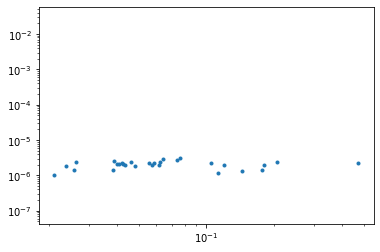

In [137]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
slps_ = slps1
slps_[slps_<1e-6] = np.nan
ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
plt.yscale('log')
plt.xscale('log')
#plt.xlim([1e-2, 1])
#plt.ylim([1e-2, 1])

#a['ebe_gcmyr'][a['erorate_est']<=0] = np.nan

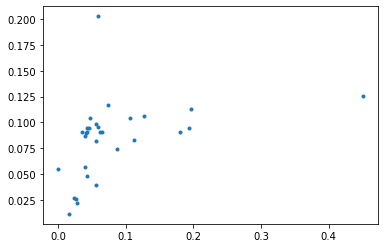

In [19]:
ax=plt.plot(slps1[:30],np.float64(a['slp_std'][:30])/1000,'.')

In [129]:
plt.imshow(f.Z,vmin=1400,vmax=1600)

0       None
1       None
2       None
3       None
4       None
        ... 
3548    None
3549    None
3550    None
3551    None
3552    None
Name: slp_50_per, Length: 3553, dtype: object

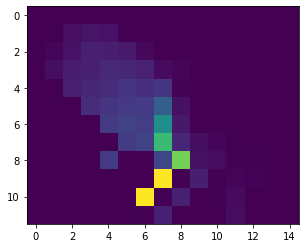

In [109]:
plt.imshow(f.A)

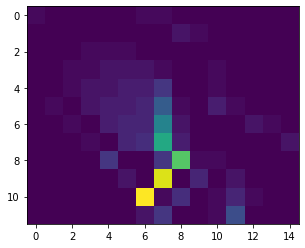

In [114]:
plt.imshow(A)

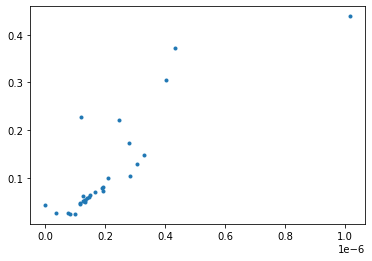

In [123]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
#ax=plt.plot(slps1[:len(a)],a['slp_ave'],'.')
ax=plt.plot(eros1[:30],np.float64(a['slp_ave'][:30])/1000,'.')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([5e-4, 1])

In [119]:
np.argmax(np.abs(slps1[1:30] - np.float64(a['slp_ave'][1:30])))

28

In [122]:
np.abs(slps1[:30] - np.float64(a['slp_ave'][:30]))

array([         nan,  46.96098842,  50.75700484,  71.54111704,
        78.03743312,  80.23575621,  69.44421396,  49.15999327,
        50.25930973,  52.85772573,  44.9630943 ,  57.55400503,
        52.35665617,  99.12596361, 372.31907539,  24.17599085,
       226.92072125, 221.36772062,  24.47363671, 104.51330118,
        25.48163325, 146.80332395,  63.45209662,  59.24415381,
       129.59319047,  61.44175092, 173.48448231,  26.57229408,
       304.703322  , 438.44988525])

In [ ]:
import seaborn as sns

In [ ]:
a.columns